In [1]:
import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [2]:
def image_arrs(paths, im_arr):
    for path in paths:
        #read images, may need to change filepath
        image = cv2.imread('../GTSRB/'+path)
        image_from_array = Image.fromarray(image, 'RGB')
        #resize all images to 30x30
        size_image = image_from_array.resize((30, 30))
        #convert images to array
        image_arr = np.array(size_image.getdata(),
                        np.uint8).reshape(size_image.size[1], size_image.size[0], 3)
        im_arr.append(image_arr.flatten())
    return im_arr

In [3]:
#this may take a minute
#may need to change file path
df = pd.read_csv('../GTSRB/Train.csv')
#all filepaths for class 1-3
paths1 = df[(df['ClassId']==1)]['Path'].values
paths2 = df[(df['ClassId']==2)]['Path'].values
paths3 = df[(df['ClassId']==3)]['Path'].values

class1_arrs = []
class1_arrs = image_arrs(paths1, class1_arrs)

class2_arrs = []
class2_arrs = image_arrs(paths2, class2_arrs)

class3_arrs = []
class3_arrs = image_arrs(paths3, class3_arrs)

In [4]:
#concat data and labels
X = class1_arrs + class2_arrs + class3_arrs
train_y = len(class1_arrs)*[0] + len(class2_arrs)*[1] + len(class3_arrs)*[2]

In [5]:
#create test set
df = pd.read_csv('../GTSRB/Test.csv')
#all filepaths for class 1-3
paths1 = df[(df['ClassId']==1)]['Path'].values
paths2 = df[(df['ClassId']==2)]['Path'].values
paths3 = df[(df['ClassId']==3)]['Path'].values

class1_arrs = []
class1_arrs = image_arrs(paths1, class1_arrs)

class2_arrs = []
class2_arrs = image_arrs(paths2, class2_arrs)

class3_arrs = []
class3_arrs = image_arrs(paths3, class3_arrs)

In [6]:
test_X = class1_arrs + class2_arrs + class3_arrs
test_y = len(class1_arrs)*[0] + len(class2_arrs)*[1] + len(class3_arrs)*[2]

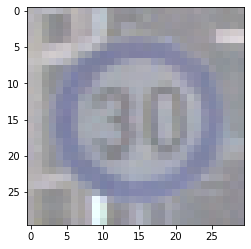

In [7]:
ex1 = X[0].reshape(30, 30, 3)
plt.imshow(ex1)

In [8]:
#mean and std of each column is 0, 1
train_X = preprocessing.scale(X, axis=1)
test_X = preprocessing.scale(test_X, axis=1)

In [9]:
#sklearn baseline
model = LogisticRegression()
model.fit(train_X, train_y)
print('Training accuracy:', model.score(train_X, train_y))
print('Test accuracy:', model.score(test_X, test_y))

C:\Users\aleja\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aleja\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training accuracy: 1.0
Test accuracy: 0.9192708333333334


In [10]:
#Convert from numpy array to tensor
train_X = torch.from_numpy(train_X).float()
train_y = torch.from_numpy(np.array(train_y)).long()
test_X = torch.from_numpy(test_X).float()
test_y = torch.from_numpy(np.array(test_y)).long()

In [11]:
class ANN(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.linear1 = nn.Linear(D, 1000)
        self.linear2 = nn.Linear(1000, 500)
        self.linear3 = nn.Linear(500, 3)
        
    def forward(self, x):
        x = torch.tanh(self.linear1(x))
        x = torch.tanh(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
model = ANN(train_X.shape[1]).to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

In [15]:
#number of iterations
epochs = 300

#used to keep track of the changes in accuracy and loss
running_loss = 0
train_accs = []
test_accs = []
losses = []

#train on gpu
train_X = train_X.to(device)
train_y = train_y.to(device)
test_X = test_X.to(device)
test_y = test_y.to(device)

#training loop
for e in range(epochs):
    #standard training steps
    pred = model.forward(train_X)
    loss = criterion(pred, train_y)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #store current loss and accuracy for test and training set
    if e%25==0 and e>0:
        running_loss /= 100
#         print("epoch:", e, "loss", running_loss/100)
        losses.append(running_loss)
        running_loss = 0
        pred = torch.argmax(pred, axis=1)
        train_acc = torch.sum(pred==train_y).float()/len(pred)
#         print('training accuracy:', train_acc.item())
        train_accs.append(train_acc.item())
        test_pred = model.forward(test_X)
        test_pred = torch.argmax(test_pred, axis=1)
        test_acc = torch.sum(test_pred==test_y).float()/len(test_pred)
#         print('test accuracy:', test_acc.item())
        test_accs.append(test_acc.item())
print('Final training accuracy:', train_accs[-1])
print('Final test accuracy:', test_accs[-1])

Final training accuracy: 0.9989796280860901
Final test accuracy: 0.9093750715255737


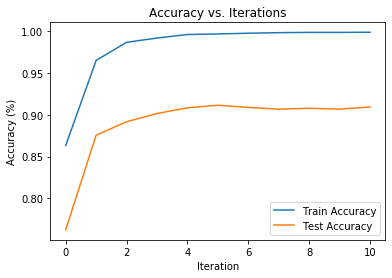

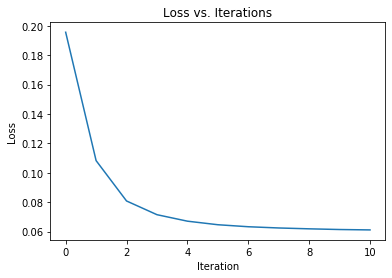

In [16]:
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
plt.plot(losses)
plt.title('Loss vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [17]:
class ANN2(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.linear1 = nn.Linear(D, 500)
        self.linear2 = nn.Linear(500, 250)
        self.linear3 = nn.Linear(250, 125)
        self.linear4 = nn.Linear(125, 50)
        self.linear5 = nn.Linear(50, 25)
        self.linear6 = nn.Linear(25, 3)
        
    def forward(self, x):
        x = torch.tanh(self.linear1(x))
        x = torch.tanh(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        x = torch.tanh(self.linear4(x))
        x = torch.tanh(self.linear5(x))
        x = torch.tanh(self.linear6(x))
        return x

In [18]:
model = ANN2(train_X.shape[1]).to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

In [20]:
#number of iterations
epochs = 300

#used to keep track of the changes in accuracy and loss
running_loss = 0
train_accs = []
test_accs = []
losses = []

#train on gpu
train_X = train_X.to(device)
train_y = train_y.to(device)
test_X = test_X.to(device)
test_y = test_y.to(device)

#training loop
for e in range(epochs):

    #standard training steps
    pred = model.forward(train_X)
    loss = criterion(pred, train_y)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #store current loss and accuracy for test and training set
    if e%25==0 and e>0:
        running_loss /= 100
#         print("epoch:", e, "loss", running_loss/100)
        losses.append(running_loss)
        running_loss = 0
        pred = torch.argmax(pred, axis=1)
        train_acc = torch.sum(pred==train_y).float()/len(pred)
#         print('training accuracy:', train_acc.item())
        train_accs.append(train_acc.item())
        test_pred = model.forward(test_X)
        test_pred = torch.argmax(test_pred, axis=1)
        test_acc = torch.sum(test_pred==test_y).float()/len(test_pred)
#         print('test accuracy:', test_acc.item())
        test_accs.append(test_acc.item())
print('Final training accuracy:', train_accs[-1])
print('Final test accuracy:', test_accs[-1])

Final training accuracy: 0.9996598958969116
Final test accuracy: 0.9083333611488342


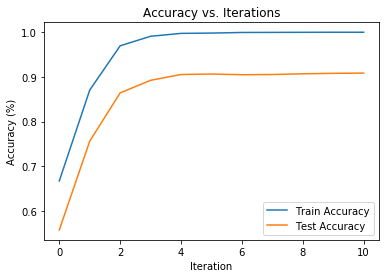

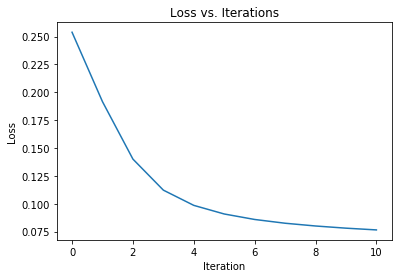

In [21]:
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
plt.plot(losses)
plt.title('Loss vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()